In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.animation import PillowWriter

## The Model

In [2]:
class Ball:
    
    def __init__(self, dis, height, mass = 1, dy = 0):
        
        self.mass   = mass                # defines the mass of the ball
        self.pos    = height              # defines initial position in y direction
        self.vel    = dy                  # defines initial velocity y direction
        self.dis    = dis                 # defines x distance to the nearest fixed point of the trampoline
        self.energy = []                  # list that holds energy of the ball (kinetic + graviational)
         

In [3]:
class Trampoline:
    
    def __init__(self, length = 1, tension = 1):
        
        self.L = length                  # defines the length of the trampoline
        self.T = tension                 # defines the tension of the trampoline's elastics
        

In [4]:
class Simulation:
    
    def __init__(self, balls, tramp, dt = 0.01):
        
        self.dt       = dt                # defines the step size of the simulation
        self.cur_time = 0                 # gives current time of simulation
        self.case     = 1                 # defines case the balls are in
        self.g        = 1                 # defines graviational acceleration
        self.balls    = balls
        self.tramp    = tramp
        self.tdraw    = self.get_tramp_points()
        self.total_E  = []
    
    
    
    '''
    This function gets the points where the ball are in contact with
    the trampoline for drawing the trampoline for the animation
    '''
    def get_tramp_points(self):
        if self.case == 1: return [0, 0, 0, 0]
        elif self.case == 2: return [0, self.balls[0].pos,  self.balls[0].pos / 2, 0]
        elif self.case == 3: return [0, self.balls[1].pos/2,  self.balls[1].pos, 0]
        elif self.case == 4: return [0, self.balls[0].pos,  self.balls[1].pos, 0]
        
        
        
    '''
    This function computes the energy of the system to analyze conservation.
    As the energy of the system is computed differently depending on the case
    the system is in, this function presents if statements and uses the formulas
    given on the paper for computing the stored energy on the trampoline.
    '''
    def get_total_energy(self):
        
        # Saving parameters to variables for better readability
        T  = self.tramp.T
        a, c = self.balls[0].dis, self.balls[1].dis
        b  = self.tramp.L - a - c
        m1, m2 = self.balls[0].mass, self.balls[1].mass
        y1, y2 = self.balls[0].pos, self.balls[1].pos
        v1, v2 = self.balls[0].vel, self.balls[1].vel
        
        kine1 = (m1 * v1**2) / 2
        grav1 = m1 * self.g * y1
        kine2 = (m2 * v2**2) / 2
        grav2 = m2 * self.g * y2
        energy = kine1 + kine2 + grav1 + grav2
        
        # append individual ball energy to respective energy lisy
        self.balls[0].energy.append(kine1 + grav1)
        self.balls[1].energy.append(kine2 + grav2)
        
        if self.case == 1: 
            self.total_E.append(energy)
            
        elif self.case == 2: 
            tramp_stored = (T * (1/a + 1/(b+c)) * y1**2) / 2
            self.total_E.append(energy + tramp_stored)
            
        elif self.case == 3: 
            tramp_stored = (T * (1/c + 1/(b+a)) * y2**2) / 2
            self.total_E.append(energy + tramp_stored)
            
        elif self.case == 4: 
            tramp_stored = T*(y1**2/a + y2**2/c + (y1 - y2)**2/b)/2
            self.total_E.append(energy + tramp_stored)

            
            
            
    def plot_total_energy(self):
        %matplotlib inline
        plt.plot(list(range(self.cur_time)), self.total_E)
        plt.title("Total Energy of the System")
        plt.xlabel("Time Step of Simulation")
        plt.ylabel("Total Energy")
        plt.show()
        
        
        
    def plot_ball_energy(self, scenario):
        %matplotlib inline
        plt.plot(list(range(self.cur_time)), self.balls[0].energy, color = 'red', label = 'ball 1')
        plt.plot(list(range(self.cur_time)), self.balls[1].energy, color = 'orange', label = 'ball 2')
        plt.legend()
        plt.title(f"Energy of Balls - Scenario {scenario}")
        plt.xlabel("Time Step of Simulation")
        plt.ylabel("Total Energy of Individual Ball")
        plt.show()
        
    
    
    '''
    This function updates the system according to the scenario it is in.
    The scenarios are:
    
       (1) no balls touch the trampoline
       (2) the left ball touches the trampoline
       (3) the right ball touches the trampoline
       (4) the two balls touch the trampoline
       
    The function also computes and stores the total energy of the system at
    all time steps to verify whether the simulation is working properly.
    '''
    def update(self, n = 10):
        
        for _ in range(n):
            if   self.case == 1: self.update_case_1()
            elif self.case == 2: self.update_case_2()
            elif self.case == 3: self.update_case_3()
            elif self.case == 4: self.update_case_4()
            self.cur_time += 1
            self.get_total_energy()

            
    
    '''
    This function implements the numerical method for solving ODEs iteratively,
    based on Runge-Kutta 4. It takes a function and a state and returns the next
    state. The function can actually be a tuple of functions as long as the state
    y has the same dimensions.
    '''
    def runge_kutta_4(self, f, y):
        t, dt = self.cur_time, self.dt
        k1 = f(t, y)
        k2 = f(t + dt/2, y + (1/2)*dt*k1)
        k3 = f(t + dt/2, y + (1/2)*dt*k2)
        k4 = f(t + dt, y + dt*k3)
        yNext = y + dt*(k1 + 2*k2 + 2*k3 + k4)/6
        return yNext
    


    '''
    This function updates the system when it is in case 1. The 2nd order ODEs
    used are 
    
    m1*y1'' = -m1*g 
    m2*y2'' = -m2*g
    
    It updates the state of the balls according to what is computed by the rk4 
    function.
    '''
    def update_case_1(self):
        
        '''
        This function is given to RK4 to find the next states. It divides the
        2nd order ODE into two 1st order ODE for each ball, resulting in four
        functions.
        '''
        def derivs(t, y):
            y1, dy1, y2, dy2 = y
            
            # Set of coupled 1st order ODEs
            dpos1 = dy1
            dpos2 = dy2
            dvel1 = - self.g
            dvel2 = - self.g
            
            return np.array((dpos1, dvel1, dpos2, dvel2))
        
        
        # update state
        state = (self.balls[0].pos, self.balls[0].vel, self.balls[1].pos, self.balls[1].vel)
        self.balls[0].pos, self.balls[0].vel, self.balls[1].pos, self.balls[1].vel = self.runge_kutta_4(derivs, state)
        
        # change scenario according to contact with trampoline 
        if   self.balls[0].pos < 0 and self.balls[1].pos > self.balls[0].pos/2: self.case = 2
        elif self.balls[1].pos < 0 and self.balls[0].pos > self.balls[1].pos/2: self.case = 3

    
    
    
    '''
    This function updates the system when it is in case 2. The 2nd order ODEs
    used are 
    
    m1*y1'' = -m1*g - T*(y1/a + y1/(b+c))
    m2*y2'' = -m2*g
    
    It updates the state of the balls according to what is computed by the rk4 
    function.
    '''
    def update_case_2(self):
         
        def derivs(t, y):
            
            # Saving parameters to variables for better readability
            y1, dy1, y2, dy2 = y
            T  = self.tramp.T
            a  = self.balls[0].dis
            b  = self.tramp.L - self.balls[0].dis - self.balls[1].dis
            c  = self.balls[1].dis
            m1 = self.balls[0].mass
            
            # Set of coupled 1st order ODEs
            dpos1 = dy1
            dpos2 = dy2
            dvel1 = - self.g - T*(y1/a + y1/(b+c))/m1
            dvel2 = - self.g
            
            return np.array((dpos1, dvel1, dpos2, dvel2))
        
        
        # update state
        state = (self.balls[0].pos, self.balls[0].vel, self.balls[1].pos, self.balls[1].vel)
        self.balls[0].pos, self.balls[0].vel, self.balls[1].pos, self.balls[1].vel = self.runge_kutta_4(derivs, state)
        
        # change scenario according to contact with trampoline 
        if   self.balls[0].pos > 0 and self.balls[1].pos > 0: self.case = 1
        elif self.balls[0].pos < 0 and self.balls[1].pos < self.balls[0].pos/2: self.case = 4
        elif self.balls[0].pos > 0 and self.balls[1].pos < 0: self.case = 3

    
    
    
    '''
    This function updates the system when it is in case 2. The 2nd order ODEs
    used are 
    
    m1*y1'' = -m1*g 
    m2*y2'' = -m2*g - T*(y2/c + y2/(b+a))
    
    It updates the state of the balls according to what is computed by the rk4 
    function.
    '''
    def update_case_3(self):
         
        def derivs(t, y):
            
            # Saving parameters to variables for better readability
            y1, dy1, y2, dy2 = y
            T  = self.tramp.T
            a  = self.balls[0].dis
            b  = self.tramp.L - self.balls[0].dis - self.balls[1].dis
            c  = self.balls[1].dis
            m2 = self.balls[1].mass

            # Set of coupled 1st order ODEs
            dpos1 = dy1
            dvel1 = - self.g
            dpos2 = dy2
            dvel2 = - self.g - T*(y2/c + y2/(a+b))/m2
            
            return np.array((dpos1, dvel1, dpos2, dvel2))
        
        
        # update state
        state = (self.balls[0].pos, self.balls[0].vel, self.balls[1].pos, self.balls[1].vel)
        self.balls[0].pos, self.balls[0].vel, self.balls[1].pos, self.balls[1].vel = self.runge_kutta_4(derivs, state)
        
        # change scenario according to contact with trampoline 
        if   self.balls[0].pos > 0 and self.balls[1].pos > 0: self.case = 1
        elif self.balls[0].pos < self.balls[1].pos / 2 and self.balls[1].pos < 0: self.case = 4
        elif self.balls[0].pos < 0 and self.balls[1].pos > 0: self.case = 2

    
    
    
    '''
    This function updates the system when it is in case 2. The 2nd order ODEs
    used are 
    
    m1*y1'' = -m1*g - T*(y1/a + (y1-y2)/b) 
    m2*y2'' = -m2*g - T*(y2/c - (y1-y2)/b)
    
    It updates the state of the balls according to what is computed by the rk4 
    function.
    '''
    def update_case_4(self):
         
        def derivs(t, y):
            
            # Saving parameters to variables for better readability
            y1, dy1, y2, dy2 = y
            T  = self.tramp.T
            a  = self.balls[0].dis
            b  = self.tramp.L - self.balls[0].dis - self.balls[1].dis
            c  = self.balls[1].dis
            m1 = self.balls[0].mass
            m2 = self.balls[1].mass
            
            # Set of coupled 1st order ODEs
            dpos1 = dy1
            dpos2 = dy2
            dvel1 = - self.g - T*(y1/a + (y1 - y2)/b) / m1                                                     
            dvel2 = - self.g - T*(y2/c - (y1 - y2)/b) / m2
            
            return np.array((dpos1, dvel1, dpos2, dvel2))                         
        
        
        # update state
        state = (self.balls[0].pos, self.balls[0].vel, self.balls[1].pos, self.balls[1].vel)
        self.balls[0].pos, self.balls[0].vel, self.balls[1].pos, self.balls[1].vel = self.runge_kutta_4(derivs, state)
        
        # change scenario according to contact with trampoline 
        if   self.balls[0].pos < 0 and self.balls[1].pos > self.balls[0].pos/2: self.case = 2
        elif self.balls[1].pos < 0 and self.balls[0].pos > self.balls[1].pos/2: self.case = 3
        elif self.balls[0].pos > 0 and self.balls[1].pos > 0: self.case = 1

            

## Running multiple simulations

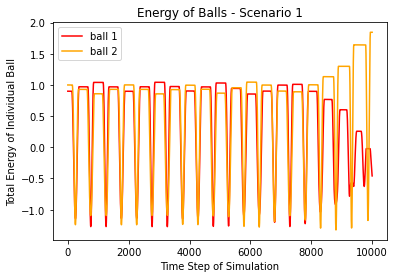

In [5]:
##############
# SCENARIO 1 #
##############

# Initialize System
tramp = Trampoline(length = 1, tension = 1)
ball1 = Ball(dis = (tramp.L / 3), height = 0.9)
ball2 = Ball(dis = (tramp.L / 3), height = 1)
sim   = Simulation([ball1, ball2], tramp)

# Update System for 1e4 Steps
sim.update(n = int(1e4))
sim.plot_ball_energy(1)

In [6]:
#########################
# INITIALIZE SIMULATION #
#########################

# Initialize System 1
tramp = Trampoline(length = 1, tension = 1)
ball1 = Ball(dis = (tramp.L / 3), height = 0.9)
ball2 = Ball(dis = (tramp.L / 3), height = 1)
sim   = Simulation([ball1, ball2], tramp)


#################
# RUN ANIMATION #
#################

%matplotlib notebook

# create figure, axis, and lines for drawing
lines  = [None, None, None]
fig    = plt.figure(figsize = (3,3))
ax     = plt.subplot(xlim = (- 0.1, sim.tramp.L + 0.1), ylim = (-3, 5))
ax.set_title("Scenario 1")

# initialize lines to certain values
lines[0], = ax.plot([sim.balls[0].dis], [sim.balls[0].pos], ms = 10, color = 'red', marker = 'o')  
lines[1], = ax.plot([sim.tramp.L - sim.balls[1].dis], [sim.balls[1].pos], ms = 10, color = 'orange', marker = 'o')  
lines[2], = ax.plot([0, sim.balls[0].dis, sim.tramp.L - sim.balls[1].dis, sim.tramp.L], 
                    sim.get_tramp_points(), color = 'black')

def animate(i):
    sim.update(n=5)
    lines[0].set_data(sim.balls[0].dis, sim.balls[0].pos)
    lines[1].set_data(sim.tramp.L - sim.balls[1].dis, sim.balls[1].pos)
    lines[2].set_data([0, sim.balls[0].dis, sim.tramp.L - sim.balls[1].dis, sim.tramp.L], sim.get_tramp_points())
    return lines
    
    
# starts animation
anim = animation.FuncAnimation(fig, animate, np.arange(1, 1000), interval = 1, blit = True)
plt.show()

<IPython.core.display.Javascript object>

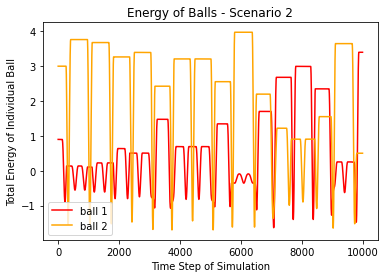

In [7]:
##############
# SCENARIO 2 #
##############

# Initialize System
tramp = Trampoline(length = 1, tension = 1)
ball1 = Ball(dis = (tramp.L / 3), height = 0.9)
ball2 = Ball(dis = (tramp.L / 3), height = 3)
sim   = Simulation([ball1, ball2], tramp)

# Update System for 1e4 Steps
sim.update(n = int(1e4))
sim.plot_ball_energy(2)

In [8]:
#########################
# INITIALIZE SIMULATION #
#########################

# Initialize System 2
tramp = Trampoline(length = 1, tension = 1)
ball1 = Ball(dis = (tramp.L / 3), height = 0.9)
ball2 = Ball(dis = (tramp.L / 3), height = 3)
sim   = Simulation([ball1, ball2], tramp)


#################
# RUN ANIMATION #
#################

%matplotlib notebook

# create figure, axis, and lines for drawing
lines  = [None, None, None]
fig    = plt.figure(figsize = (3,3))
ax     = plt.subplot(xlim = (- 0.1, sim.tramp.L + 0.1), ylim = (-3, 5))

ax.set_title("Scenario 2")

# initialize lines to certain values
lines[0], = ax.plot([sim.balls[0].dis], [sim.balls[0].pos], ms = 10, color = 'red', marker = 'o')  
lines[1], = ax.plot([sim.tramp.L - sim.balls[1].dis], [sim.balls[1].pos], ms = 10, color = 'orange', marker = 'o')  
lines[2], = ax.plot([0, sim.balls[0].dis, sim.tramp.L - sim.balls[1].dis, sim.tramp.L], 
                    sim.get_tramp_points(), color = 'black')

def animate(i):
    sim.update(n=5)
    lines[0].set_data(sim.balls[0].dis, sim.balls[0].pos)
    lines[1].set_data(sim.tramp.L - sim.balls[1].dis, sim.balls[1].pos)
    lines[2].set_data([0, sim.balls[0].dis, sim.tramp.L - sim.balls[1].dis, sim.tramp.L], sim.get_tramp_points())
    return lines
    
    
# starts animation
anim = animation.FuncAnimation(fig, animate, np.arange(1, 1000), interval = 1, blit = True)
plt.show()

<IPython.core.display.Javascript object>

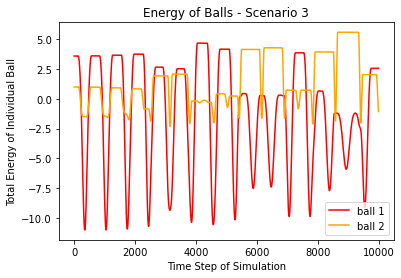

In [9]:
##############
# SCENARIO 3 #
##############

# Initialize System
tramp = Trampoline(length = 1, tension = 1)
ball1 = Ball(dis = (tramp.L / 3), height = 0.9, mass = 4)
ball2 = Ball(dis = (tramp.L / 3), height = 1, mass = 1)
sim   = Simulation([ball1, ball2], tramp)

# Update System for 1e4 Steps
sim.update(n = int(1e4))
sim.plot_ball_energy(3)

In [10]:
#########################
# INITIALIZE SIMULATION #
#########################

# Initialize System 3
tramp = Trampoline(length = 1, tension = 1)
ball1 = Ball(dis = (tramp.L / 3), height = 0.9, mass = 4)
ball2 = Ball(dis = (tramp.L / 3), height = 1, mass = 1)
sim   = Simulation([ball1, ball2], tramp)


#################
# RUN ANIMATION #
#################

%matplotlib notebook

# create figure, axis, and lines for drawing
lines  = [None, None, None]
fig    = plt.figure(figsize = (3,3))
ax     = plt.subplot(xlim = (- 0.1, sim.tramp.L + 0.1), ylim = (-3, 5))

ax.set_title("Scenario 3")

# initialize lines to certain values
lines[0], = ax.plot([sim.balls[0].dis], [sim.balls[0].pos], ms = 10, color = 'red', marker = 'o')  
lines[1], = ax.plot([sim.tramp.L - sim.balls[1].dis], [sim.balls[1].pos], ms = 10, color = 'orange', marker = 'o')  
lines[2], = ax.plot([0, sim.balls[0].dis, sim.tramp.L - sim.balls[1].dis, sim.tramp.L], 
                    sim.get_tramp_points(), color = 'black')

def animate(i):
    sim.update(n=5)
    lines[0].set_data(sim.balls[0].dis, sim.balls[0].pos)
    lines[1].set_data(sim.tramp.L - sim.balls[1].dis, sim.balls[1].pos)
    lines[2].set_data([0, sim.balls[0].dis, sim.tramp.L - sim.balls[1].dis, sim.tramp.L], sim.get_tramp_points())
    return lines
    
    
# starts animation
anim = animation.FuncAnimation(fig, animate, np.arange(1, 1000), interval = 1, blit = True)
plt.show()

<IPython.core.display.Javascript object>

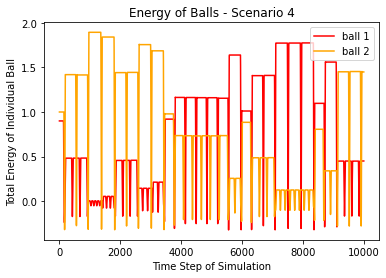

In [11]:
##############
# SCENARIO 4 #
##############

# Initialize System
tramp = Trampoline(length = 1, tension = 10)
ball1 = Ball(dis = (tramp.L / 3), height = 0.9)
ball2 = Ball(dis = (tramp.L / 3), height = 1)
sim   = Simulation([ball1, ball2], tramp)

# Update System for 1e4 Steps
sim.update(n = int(1e4))
sim.plot_ball_energy(4)

In [12]:
#########################
# INITIALIZE SIMULATION #
#########################

# Initialize System 4
tramp = Trampoline(length = 1, tension = 10)
ball1 = Ball(dis = (tramp.L / 3), height = 0.9)
ball2 = Ball(dis = (tramp.L / 3), height = 1)
sim   = Simulation([ball1, ball2], tramp)


#################
# RUN ANIMATION #
#################

%matplotlib notebook

# create figure, axis, and lines for drawing
lines  = [None, None, None]
fig    = plt.figure(figsize = (3,3))
ax     = plt.subplot(xlim = (- 0.1, sim.tramp.L + 0.1), ylim = (-3, 5))

ax.set_title("Scenario 4")

# initialize lines to certain values
lines[0], = ax.plot([sim.balls[0].dis], [sim.balls[0].pos], ms = 10, color = 'red', marker = 'o')  
lines[1], = ax.plot([sim.tramp.L - sim.balls[1].dis], [sim.balls[1].pos], ms = 10, color = 'orange', marker = 'o')  
lines[2], = ax.plot([0, sim.balls[0].dis, sim.tramp.L - sim.balls[1].dis, sim.tramp.L], 
                    sim.get_tramp_points(), color = 'black')

def animate(i):
    sim.update(n=5)
    lines[0].set_data(sim.balls[0].dis, sim.balls[0].pos)
    lines[1].set_data(sim.tramp.L - sim.balls[1].dis, sim.balls[1].pos)
    lines[2].set_data([0, sim.balls[0].dis, sim.tramp.L - sim.balls[1].dis, sim.tramp.L], sim.get_tramp_points())
    return lines
    
    
# starts animation
anim = animation.FuncAnimation(fig, animate, np.arange(1, 1000), interval = 1, blit = True)
plt.show()

<IPython.core.display.Javascript object>

## Number of times ball 1 ends with more energy than ball 2

In [13]:
count = 0
iters = 200
for _ in range(iters):

    # Initialize System
    tramp = Trampoline(length = 1, tension = np.random.choice([1, 2, 3, 4, 5]))
    ball1 = Ball(dis = (tramp.L / 3), height = np.random.uniform(0.5, 3))
    ball2 = Ball(dis = (tramp.L / 3), height = np.random.uniform(0.5, 3))
    sim   = Simulation([ball1, ball2], tramp)

    # Update System for 1e4 Steps
    sim.update(n = int(1e4))
    if sim.balls[0].energy[-1] > sim.balls[1].energy[-1]: count += 1
        
print(f"Proportion of times ball 1 ended with larger energy than ball 2: {count/iters}")

Proportion of times ball 1 ended with larger energy than ball 2: 0.55
